# Ataki adwersarialne

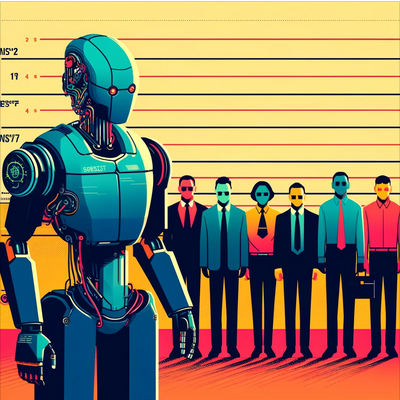

## Wstęp
Jak pewnie słyszałaś/eś, sieci neuronowe są świetnym narzędziem do klasyfikacji obiektów, rozpoznawania złożonych zależności czy przewidywania przyszłych wartości na podstawie historycznych danych. Okazuje się, że są one przy tym podatne na ataki, które mogą znacząco osłabić ich działanie. Ataki te polegają na znalezieniu luki w rozumowaniu modelu. Załóżmy, że sieć nauczyła się rozpoznawać rower na zdjęciu. Spróbujmy inteligentnie zmodyfikować wybrane piksele z obszaru przedstawiającego rower tak, aby "gołym okiem" obrazek nadal przedstawiał rower. Zapytajmy sieć neuronową, czy nadal "widzi" rower na tak zmodyfikowanym obrazku. Jeżeli model nie zaklasyfikuje już obiektu jako rower, wówczas można stwierdzić, że **atak adwersarialny** się powiódł. **Atakiem adwersarialnym** nazywamy takie spreparowanie danych wejściowych, aby jak najskuteczniej zmylić sieć podczas podejmowania przez nią decyzji.

## Zadanie
Zaproponuj metodę włamania się do sieci neuronowej (ataku adwersarialnego), by obniżyć prawdopodobieństwo przypisania próbki do właściwej klasy, przy możliwie małych modyfikacjach testowanych obrazów. 

Naszym kryterium będzie iloczyn wartości `structural similarity index` ([SSIM](https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html)) uśrednionego po wszystkich obrazach biorących udział w ataku, z wartością różnicy pomiędzy początkową dokładnością modelu na danym zbiorze, a jego dokładnością na tym samym zbiorze poddanym modyfikacjom, zgodnie ze wzorem:  
$$SSIM \cdot (base_{acc} - final_{acc})$$
gdzie:
- $base_{acc}$ jest dokładnością klasyfikacji modelu na niezmodyfikowanym zbiorze testowym;
- $final_{acc}$ jest dokładnością klasyfikacji modelu na zmodyfikowanym zbiorze.

Powyższe kryterium i wszystkie wymagane do niego funkcje są zaimplementowane poniżej przez nas.

## Ograniczenia
- Twoje finalne rozwiązanie będzie testowane w środowisku z GPU.
- Rozpatrywane będą wyłącznie rozwiązania, w których maksymalna odległość między pikselami oryginalnego obrazu a odpowiadającymi im pikselami po ataku adwersarialnym (w sensie wartości bezwzględnej) nie będzie większa niż $0.3$. Obrazy po atakach porównywane są do oryginalnych obrazów znormalizowanych do przedziału $<-1, 1>$.         
  **PRZYKŁAD:** Wektory $[-1.0, 0.2, 0.5, -0.3]$ oraz $[-0.9, 0.1, 0.8, 0.0]$ są poprawne, ponieważ wektor różnic bezwzględnych pomiędzy nimi $[0.1, 0.1, 0.3, 0.3]$ nie zawiera elementów większych niż $0.3$. Natomiast wektory $[0.2, 0.5, -1.0, -0.4]$ oraz $[0.3, -0.9, -0.9, -0.6]$ już nie są poprawne, ponieważ drugie elementy obu wektorów różnią się od siebie o $1.4 > 0.3$.
- Funkcja `perturbe_dataset()` ma przyjmować trójwymiarową tablicę typu Numpy o rozmiarze (liczba próbek x 28 x 28) i zwracać tablicę typu Numpy o rozmiarze (liczba próbek x 28 x 28), która będzie zbiorem po modyfikacji. Podczas tworzenia zmodyfikowanej wersji zbioru danych można korzystać z wszelkich informacji pochodzących z wytrenowanego modelu.
- Twój atak powinien zostać przeprowadzony w maksymalnie 5 minut używając Google Colab z GPU.


## Uwagi i wskazówki
- Model został wytrenowany na zbiorze, w którym każdy z obrazów został z osobna znormalizowany do przedziału $<-1, 1>$, zarówno w zbiorze treningowym jak i walidacyjnym. Zbiór testowy, który nie jest dołączony do instrukcji zadania, będzie znormalizowany w analogiczny sposób.
- Każdy obraz zbioru testowego będzie finalnie normalizowany do zakresu $<-1, 1>$, ale obrazy po modyfikacji, czyli na wyjściu funkcji `perturbe_dataset()`, będą jedynie przekształcane do postaci tensora i nie będą poddawane normalizacji.
- Swoje rozwiązania możesz testować na zbiorze treningowym i walidacyjnym, ale punktacja za zadanie zostanie przyznana jedynie na podstawie wyniku na zbiorze testowym.

## Pliki zgłoszeniowe
 Tylko ten notebook. 

## Ewaluacja
Pamiętaj, że podczas sprawdzania flaga `FINAL_EVALUATION_MODE` zostanie ustawiona na `True`. Za pomocą skryptu `validation_script.py` będziesz mógł upewnić się, że Twoje rozwiązanie zostanie prawidłowo wykonane na naszych serwerach oceniających. 

# Kod startowy

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################
FINAL_EVALUATION_MODE = False 
# W czasie sprawdzania Twojego rozwiązania, zmienimy tę wartość na True
# Wartość tej flagi M U S I zostać ustawiona na False w rozwiązaniu, które nam nadeślesz!

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
import os
from copy import deepcopy

import gdown
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

## Ładowanie danych

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
if not FINAL_EVALUATION_MODE:
    if not os.path.exists(f"data"):
        gdown.download_folder(url="https://drive.google.com/drive/folders/1qmRd5O-LdOki1-HC4dgfaNrstzG3h_cN?usp=sharing", output=f"./data")

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Klasa zbioru danych
class ContestDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = Image.fromarray(self.data[index])
        if self.transform:
            x = self.transform(x)
        y = self.labels[index]
        return x, y

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Funkcja do normalizacji wartości pikseli do przedziału <-1, 1>
def normalize_samples(samples):
    assert len(samples.shape) == 3
    samples = samples.reshape(-1, 28 * 28)
    minimum_values = np.min(samples, axis=1)
    maximum_values = np.max(samples, axis=1)

    normalized_samples = (2 * (samples - minimum_values[:, np.newaxis]) / \
                          (maximum_values - minimum_values)[:, np.newaxis]) - 1
    
    normalized_samples = normalized_samples.reshape(
        normalized_samples.shape[0], 28, 28
    )
    return normalized_samples

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Wczytajmy potrzebne dane
# X_train oraz y_train posłużą Ci do przygotowania ataku adwersarialnego
# Na X_validation oraz y_validation sprawdzisz czy Twoje rozwiązanie przechodzi skrypt ewaluacyjny
path_to_data = './data/'

X_train = np.load(f'{path_to_data}contest_train_samples.npy') / 255.
y_train = np.load(f'{path_to_data}contest_train_labels.npy')
X_validation = np.load(f'{path_to_data}contest_validation_samples.npy') / 255.
y_validation = np.load(f'{path_to_data}contest_validation_labels.npy')

X_train = normalize_samples(X_train)
X_validation = normalize_samples(X_validation)

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
validation_set = ContestDataset(X_validation,
                                y_validation,
                                transform=transforms.ToTensor())
validation_loader = DataLoader(validation_set,
                                batch_size=1,
                                shuffle=False)

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Definicja klasyfikatora, który chcemy oszukać!
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(64 * 11 * 11, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.pool(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Stwórzmy nasz klasyfikator
net = Net()

# Wczytajmy pretrenowane wagi do naszego modelu
net.load_state_dict(torch.load('trained_model.pth',
                               map_location=device))

## Kod z kryteriami oceniającymi

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

def evaluate_network(data_loader,
                     model,
                     device,
                     verbose=True):
    # Dokonajmy ewaluacji wytrenowanego modelu na wybranym zbiorze
    all_predictions, all_labels = [], []
    model.to(device)
    # Sieć neuronowa musi zostać przeniesiona do trybu ewaluacji
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # Wybieramy klasę o najwyższym prawdopodobieństwie przynależności
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.append(predicted.ravel())
            all_labels.append(labels.ravel())
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    # Sprawdzamy, ile etykiet zostało prawidłowo wytypowanych przez sieć
    correct = (all_predictions == all_labels).sum().item()
    accuracy = (100 * correct / all_labels.size()[0])
    no_of_elements = len(data_loader.dataset)
    if verbose:
        print(f'Dokładność klasyfikacji na {no_of_elements} obrazów wybranego zbioru wynosi '
              f'{accuracy} %.')
    return accuracy

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Funkcja do wyliczenia SSIM oraz maksymalnej odległości między odpowiadającymi pikselami
def calculate_similarity(original_dataset,
                         perturbed_dataset):
    # Zarówno original_dataset jak i perturbed_dataset mają być typu Numpy array.
    # Mają mieć taki sam rozmiar, tj. (liczba elementów x 28 x 28)
    assert original_dataset.shape == perturbed_dataset.shape
    assert original_dataset.shape[1] == original_dataset.shape[2] == 28
    assert perturbed_dataset.shape[1] == perturbed_dataset.shape[2] == 28
    similarities, L1_distances = [], []
    for i in range(original_dataset.shape[0]):
        original_element = original_dataset[i].ravel()
        perturbed_element = perturbed_dataset[i].ravel()
        similarities.append(
            ssim(
                original_element,
                perturbed_element,
                data_range=2)
            )
        L1_distances.append(
            np.max(np.abs(
                original_element - perturbed_element
            ))
        )
    mean_SSIM = np.mean(similarities)
    max_distance = np.max(L1_distances)
    print(f'Średnia wartość SSIM wynosi {mean_SSIM}, a największa odległość między pikselami wynosi: {max_distance}.')
    return mean_SSIM, max_distance

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
if not FINAL_EVALUATION_MODE:
    result = evaluate_network(
        validation_loader,
        net,
        device,
        verbose=True
    )

# Twoje rozwiązanie

To jest jedyna sekcja, w której musisz coś zrobić.

In [ ]:
def perturbe_dataset(original_dataset):
    """
    To tutaj masz przygotować funkcję do zaburzania zbioru danych. Na wejściu ma znajdować
    się tablica typu Numpy array o rozmiarze (liczba elementów, 28, 28). Podobnie ma być na
    wyjściu. A co wydarzy się po drodze? To już zależy od Ciebie i Twojej pomysłowości!
    """
    assert len(original_dataset.shape) == 3
    # TODO:
    perturbed_dataset = deepcopy(original_dataset)
    assert len(perturbed_dataset.shape) == 3
    assert perturbed_dataset.shape[1] == 28
    assert perturbed_dataset.shape[2] == 28
    return perturbed_dataset

# Ewaluacja

Poniższy kod będzie służył ewaluacji rozwiązania. Po wysłaniu rozwiązania do nas zostanie wykonana funkcja `evaluate_algorithm(net, X_validation, y_validation, device, perturbe_dataset)`, t.j. prawie identyczny kod jak niżej będzie się uruchamiał na katalogu zdjęć `test_data` dostępnym tylko dla sprawdzających zadania.

Upewnij się przed wysłaniem, że cały notebook wykonuje się od początku do końca bez błędów i bez ingerencji użytkownika po wykonaniu polecenia `Run All`.

In [ ]:
def evaluate_algorithm(model, images, labels, device, perturbe_algorithm):
    dataset_for_perturbation = deepcopy(images)
    dataset_attacked = perturbe_algorithm(dataset_for_perturbation)

    SSIM, distance = calculate_similarity(
        dataset_for_perturbation,
        dataset_attacked
    )
    assert distance <= 0.3

    perturbed_set = ContestDataset(dataset_attacked,
                                labels,
                                transform=transforms.ToTensor())
    perturbed_loader = DataLoader(perturbed_set,
                                batch_size=64,
                                shuffle=False)
    perturbed_accuracy = evaluate_network(
        perturbed_loader,
        model,
        device,
        verbose=True
    )

In [ ]:
if not FINAL_EVALUATION_MODE:
    evaluate_algorithm(net, X_validation, y_validation, device, perturbe_dataset)